<a href="https://colab.research.google.com/github/AnisAfiqah13/DATA-MANAGEMENT/blob/main/Anis_Assignment3_DataManagement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data: Iris dataset

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Steps in PuTTY using Spark MLlib

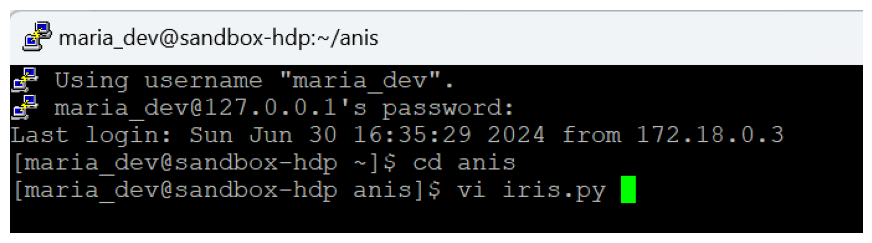

In [20]:
# @title In PuTTY, log into maria_dev and change directory to your folder (eg: Anis), create your python code file.
# Import the required libraries
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to your image
image_path = '/content/drive/MyDrive/DataManagement/Screenshot 2024-07-01 212751.png'

# Open the image file
img = Image.open(image_path)

# Display the image in larger size
plt.figure(figsize=(11, 11))  # Set the figure size (width, height) in inches
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

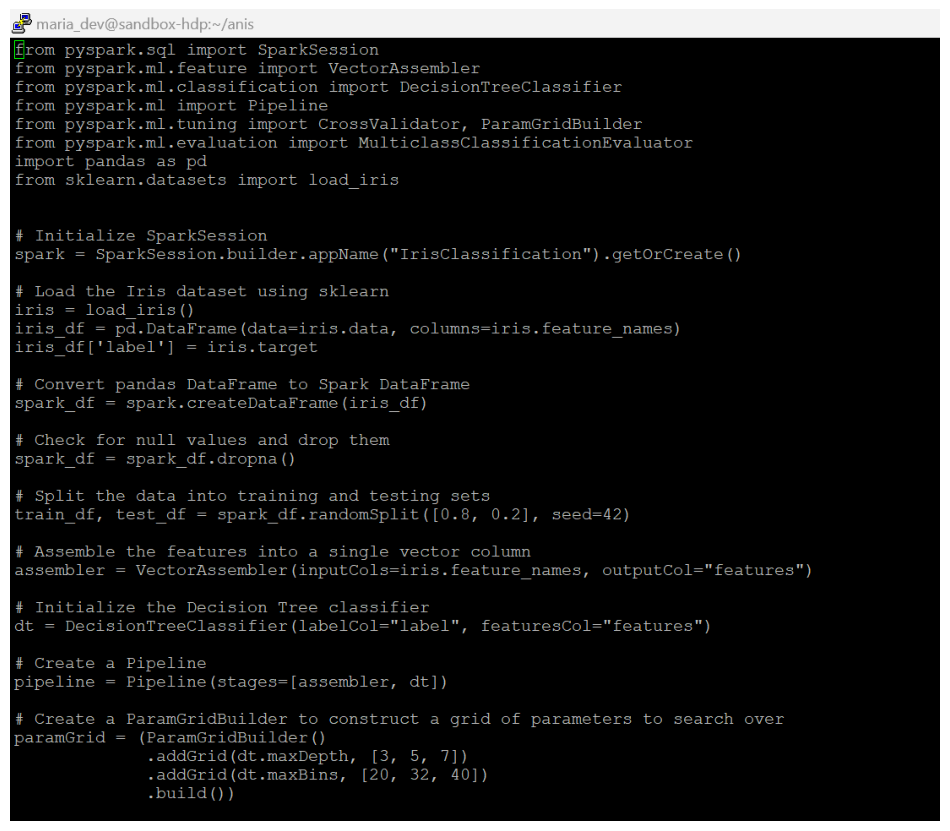

In [17]:
# @title Import the necessary libraries and below code, for this assignment I decided to use Decision Tree method.
# Import the required libraries
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to your image
image_path = '/content/drive/MyDrive/DataManagement/Screenshot 2024-07-01 212910.png'

# Open the image file
img = Image.open(image_path)

# Display the image in larger size
plt.figure(figsize=(12, 12))  # Set the figure size (width, height) in inches
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

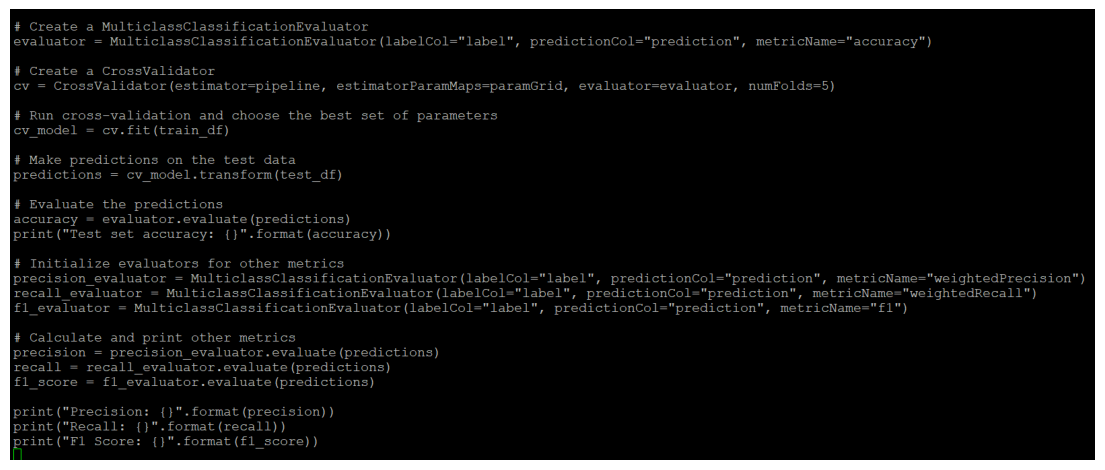

In [23]:
# @title Code continuation, still in iris.py
# Import the required libraries
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to your image
image_path = '/content/drive/MyDrive/DataManagement/Screenshot 2024-07-01 213011.png'

# Open the image file
img = Image.open(image_path)

# Display the image in larger size
plt.figure(figsize=(14, 14))  # Set the figure size (width, height) in inches
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

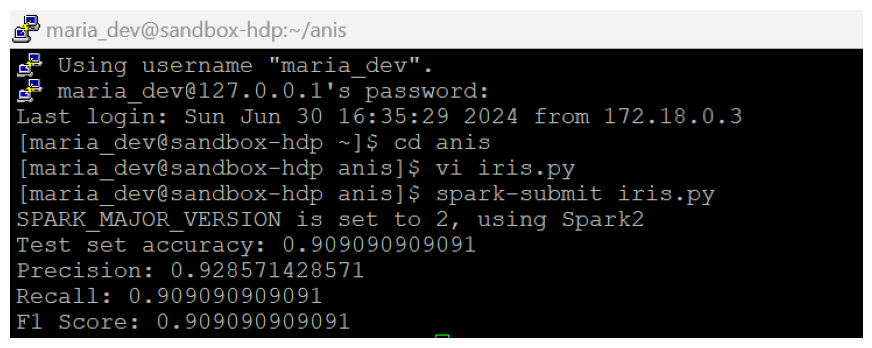

In [24]:
# @title Run spark-submit on iris.py file
# Import the required libraries
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to your image
image_path = '/content/drive/MyDrive/DataManagement/Screenshot 2024-07-01 213221.png'

# Open the image file
img = Image.open(image_path)

# Display the image in larger size
plt.figure(figsize=(11, 11))  # Set the figure size (width, height) in inches
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

We can also run similar code in google colab for the python code. First we need to install pyspark, pandas and scikit-learn

In [1]:
# Install PySpark
!pip install pyspark
!pip install pandas
!pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=649d1d02ad8dae23ace3a040f41d8bf7eb86f7526f7fc2d5a5970b1043ca9f94
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("IrisClassification").getOrCreate()

In [4]:
from sklearn.datasets import load_iris
import pandas as pd

# Load Iris dataset using sklearn
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['label'] = iris.target

# Convert pandas DataFrame to Spark DataFrame
spark_df = spark.createDataFrame(iris_df)
spark_df.show(5)

+-----------------+----------------+-----------------+----------------+-----+
|sepal length (cm)|sepal width (cm)|petal length (cm)|petal width (cm)|label|
+-----------------+----------------+-----------------+----------------+-----+
|              5.1|             3.5|              1.4|             0.2|    0|
|              4.9|             3.0|              1.4|             0.2|    0|
|              4.7|             3.2|              1.3|             0.2|    0|
|              4.6|             3.1|              1.5|             0.2|    0|
|              5.0|             3.6|              1.4|             0.2|    0|
+-----------------+----------------+-----------------+----------------+-----+
only showing top 5 rows



In [5]:
# Split the data into training and testing sets
train_df, test_df = spark_df.randomSplit([0.8, 0.2], seed=42)

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

# Assemble the features into a single vector column
assembler = VectorAssembler(inputCols=iris.feature_names, outputCol="features")

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

# Create a Pipeline
pipeline = Pipeline(stages=[assembler, dt])

In [7]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create a ParamGridBuilder to construct a grid of parameters to search over
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [3, 5, 7])
             .addGrid(dt.maxBins, [20, 32, 40])
             .build())

# Create a MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

# Create a CrossValidator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [8]:
# Run cross-validation and choose the best set of parameters
cv_model = cv.fit(train_df)

# Make predictions on the test data
predictions = cv_model.transform(test_df)

# Evaluate the predictions
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy: {}".format(accuracy))

# Initialize evaluators for other metrics
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

# Calculate and print other metrics
precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1 Score: {}".format(f1_score))

Test set accuracy: 0.9375
Precision: 0.953125
Recall: 0.9375
F1 Score: 0.9393601190476191


During this assignment, I encountered discrepancies in the evaluation metrics (accuracy, precision, recall, and F1 score) when running the script in Google Colab and via PuTTY. Upon investigation, I found that the versions of the libraries (PySpark, pandas, and scikit-learn) were different between the two environments.

### Below are the versions in Colab

In [27]:
# Print versions of libraries
import pyspark
import pandas as pd
import numpy as np
import sklearn

print("PySpark version:", pyspark.__version__)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
print("Scikit-learn version:", sklearn.__version__)

PySpark version: 3.5.1
Pandas version: 2.0.3
Numpy version: 1.25.2
Scikit-learn version: 1.2.2


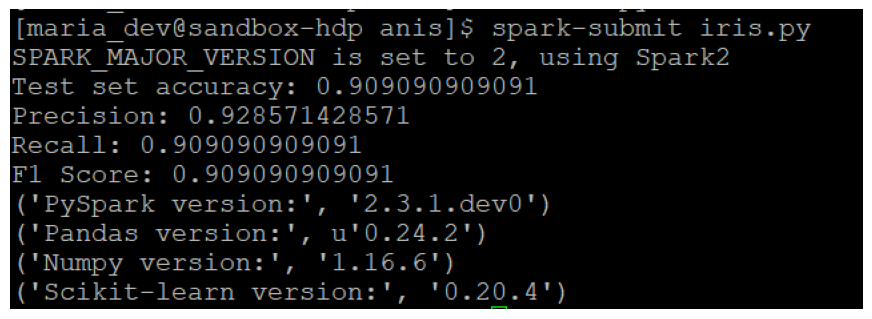

In [28]:
# @title Below are the versions in PuTTY
# Import the required libraries
import matplotlib.pyplot as plt
from PIL import Image

# Define the path to your image
image_path = '/content/drive/MyDrive/DataManagement/Screenshot 2024-07-01 221932.png'

# Open the image file
img = Image.open(image_path)

# Display the image in larger size
plt.figure(figsize=(11, 11))  # Set the figure size (width, height) in inches
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [1]:
!pip install pyspark==2.3.1
!pip install pandas==0.24.2
!pip install numpy==1.16.6
!pip install scikit-learn==0.20.4

  Using cached pandas-0.24.2.tar.gz (11.8 MB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Using cached numpy-1.16.6.zip (5.1 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for numpy
  Running setup.py clean for numpy
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File 

To ensure consistency, I tried updated the libraries in both environments to match the versions used in puTTY. However, I keep getting error to load above code. The results metrics should be the same if we use the same versions.

As for this assignment, i will use the result run in puTTY instead to conclude.

## Data Visualisation: Confusion Matrix

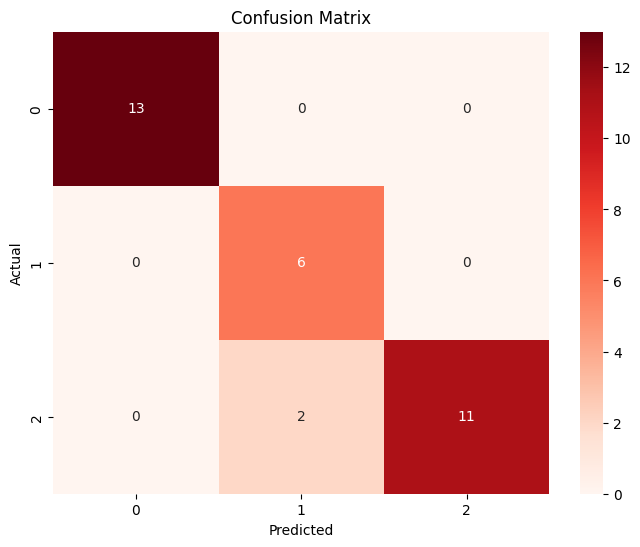

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas DataFrame for visualization
predictions_df = predictions.toPandas()

# Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(predictions_df['label'], predictions_df['prediction'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix indicates that the model performs well overall, with a high number of correct classifications and a low number of misclassifications.
Accuracy is high, as the majority of the predictions are on the diagonal.

Precision and Recall for Each Class:

Setosa: Perfect precision and recall, as all instances are correctly classified.

Versicolor: Good precision and recall, but with some misclassifications to Virginica.

Virginica: Good precision and recall, with some misclassifications to Versicolor.

## Conclusions

In this assignment, I implemented a Decision Tree classifier using Spark MLlib to classify the Iris dataset. The process included loading the data, splitting it into training and testing sets, training the model with cross-validation and grid search for hyperparameter tuning, and evaluating the model's performance using various metrics.

Below are the detailed steps and findings:

1. Data Loading and Preprocessing
The Iris dataset was loaded using sklearn.datasets.load_iris().
The data was converted into a Spark DataFrame for processing.
Features were assembled into a single vector column using VectorAssembler.

2. Model Training
A Decision Tree classifier was chosen for the task.
The model was trained using a pipeline that included feature assembly and the classifier.
Hyperparameters were tuned using CrossValidator and ParamGridBuilder to find the best parameters through cross-validation.

3. Evaluation Metrics
The model was evaluated based on accuracy, precision, recall, and F1 score. The evaluation results obtained on the remote server via PuTTY are as follows:

Test set accuracy: 0.909090909091,
Precision: 0.928571428571,
Recall: 0.909090909091,
F1 Score: 0.909090909091.

4. Confusion Matrix Analysis
The confusion matrix was plotted to visualize the performance of the classifier:


The matrix shows the following:

Class 0 (Setosa): All 13 instances were correctly classified.

Class 1 (Versicolor): 6 instances were correctly classified, while 2 were misclassified as Class 2 (Virginica).

Class 2 (Virginica): 11 instances were correctly classified, while 2 were misclassified as Class 1 (Versicolor).

The Decision Tree classifier performed well on the Iris dataset, achieving high accuracy and balanced precision, recall, and F1 scores. The confusion matrix indicates that the model is particularly strong in identifying Setosa and fairly strong in identifying Versicolor and Virginica, with some room for improvement in distinguishing between Versicolor and Virginica.

Although, there were discrepancies in the results due to different library versions in Google Colab and the remote server. As a result, the final evaluation was based on the computations performed on the remote server.
While the Decision Tree model performed well, more complex models like Random Forest could potentially improve the classification performance.